In [1]:
pip install ucimlrepo pandas seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


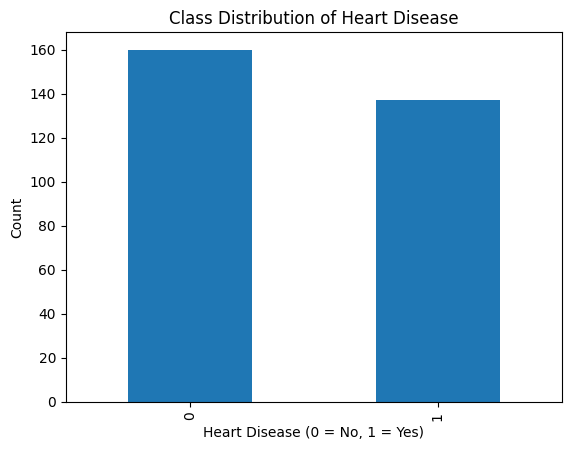

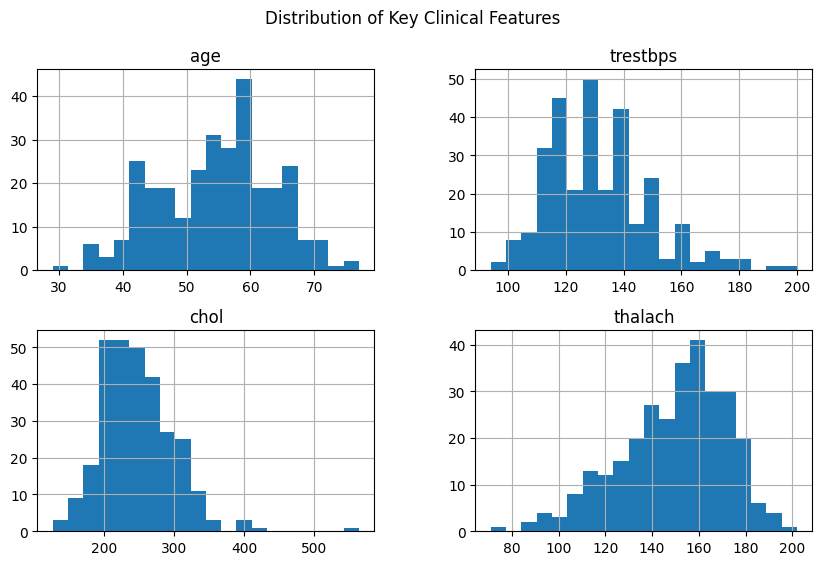

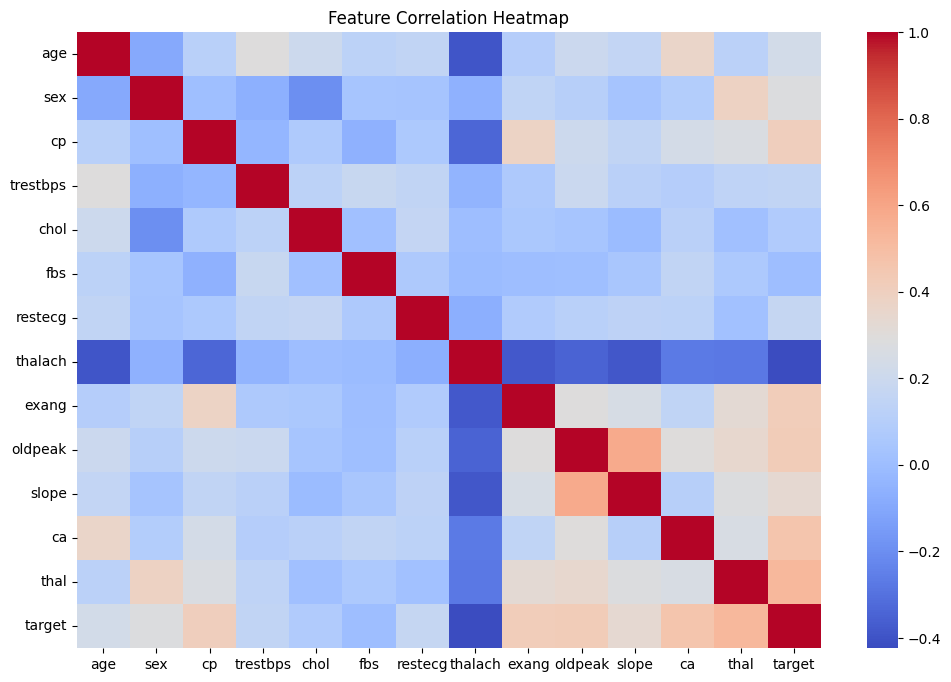

Final encoded dataset shape: (297, 19)


In [19]:
# ============================================================
# Heart Disease UCI Dataset
# Data Acquisition, Preprocessing, and EDA (5 Marks)
# ============================================================

# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# 2. Fetch the Heart Disease (Cleveland) dataset from UCI
# Dataset ID = 45 (official UCI identifier)
import pandas as pd

# Column names as per UCI Heart Disease dataset
columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg",
    "thalach","exang","oldpeak","slope","ca","thal","target"
]

# Load data from local file
df = pd.read_csv("../data/processed_heart.csv", names=columns)

# Basic cleaning
df = df.replace("?", pd.NA).dropna()
df = df.astype(float)

# Binary target
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

df.head()

# ============================================================
# Exploratory Data Analysis (EDA)
# ============================================================

# 8. Class balance visualization
# Checks whether the dataset is balanced for classification
df['target'].value_counts().plot(kind='bar')
plt.title("Class Distribution of Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# 9. Distribution of key numerical features
# Helps understand spread, skewness, and typical value ranges
df[['age', 'trestbps', 'chol', 'thalach']].hist(
    bins=20, figsize=(10,6)
)
plt.suptitle("Distribution of Key Clinical Features")
plt.show()

# 10. Correlation heatmap
# Identifies relationships between features and the target variable
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# ============================================================
# Data Encoding (for Machine Learning Models)
# ============================================================

# 11. One-hot encode categorical variables
# Encoding is done AFTER EDA to preserve interpretability during analysis
df_encoded = pd.get_dummies(
    df,
    columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'],
    drop_first=True
)

# Final dataset (df_encoded) is now ready for model training
print("Final encoded dataset shape:", df_encoded.shape)


In [ ]:
# ============================================================
# Full Training, Comparison, Evaluation + MLflow Tracking
# ============================================================

# --------- Imports ---------
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --------- Load Data ---------
X = df.drop(columns='target')   # features
y = df['target']                # binary target

# 3. Identify numerical and categorical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# 4. Define preprocessing steps
# - Scale numerical features
# - One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

# --------- CV & Metrics ---------
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------- MLflow Experiment ---------
mlflow.set_experiment("Heart Disease Model Comparison")

# ============================================================
# Logistic Regression
# ============================================================
logreg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, solver='liblinear'))
])

logreg_param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2']
}

logreg_grid = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    cv=5,
    scoring='roc_auc'
)

with mlflow.start_run(run_name="Logistic_Regression"):

    logreg_grid.fit(X, y)
    best_logreg = logreg_grid.best_estimator_

    logreg_scores = cross_validate(
        best_logreg, X, y, cv=cv, scoring=scoring
    )

    logreg_metrics = {
        metric: logreg_scores['test_' + metric].mean()
        for metric in scoring
    }

    mlflow.log_param("model_type", "LogisticRegression")
    for p, v in logreg_grid.best_params_.items():
        mlflow.log_param(p, v)

    for m, v in logreg_metrics.items():
        mlflow.log_metric(m, v)

    mlflow.sklearn.log_model(best_logreg, "model")

    print("Logistic Regression (Mean CV Scores)")
    for m, v in logreg_metrics.items():
        print(f"{m}: {v:.3f}")

# ============================================================
# Random Forest
# ============================================================
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='roc_auc'
)

with mlflow.start_run(run_name="Random_Forest"):

    rf_grid.fit(X, y)
    best_rf = rf_grid.best_estimator_

    rf_scores = cross_validate(
        best_rf, X, y, cv=cv, scoring=scoring
    )

    rf_metrics = {
        metric: rf_scores['test_' + metric].mean()
        for metric in scoring
    }

    mlflow.log_param("model_type", "RandomForest")
    for p, v in rf_grid.best_params_.items():
        mlflow.log_param(p, v)

    for m, v in rf_metrics.items():
        mlflow.log_metric(m, v)

    mlflow.sklearn.log_model(best_rf, "model")

    print("\nRandom Forest (Mean CV Scores)")
    for m, v in rf_metrics.items():
        print(f"{m}: {v:.3f}")

print("\n Experiments logged successfully in MLflow")


/home/lokanath/mlops-bits-113/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/lokanath/mlops-bits-113/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/lokanath/mlops-bits-113/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of

Logistic Regression (Mean CV Scores)
accuracy: 0.818
precision: 0.828
recall: 0.766
roc_auc: 0.892


2025/12/25 21:00:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Random Forest (Mean CV Scores)
accuracy: 0.835
precision: 0.862
recall: 0.766
roc_auc: 0.900

 Experiments logged successfully in MLflow
